In [2]:
# system
import warnings
import os

# processing
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler

# modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# performance 
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, roc_auc_score, \
confusion_matrix, classification_report

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
%config InlineBackend.figure_format = 'retina'

In [3]:
df = pd.read_csv('../artifacts/data.csv')
df1 = df.query('Premium_Level == 1')
df2 = df.query('Premium_Level > 1')
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Premium_Level,Premium_Log
0,1,1,44,1,28.0,0,3,1,40454.0,26.0,217,1,3.0,4.606961
1,2,1,76,1,3.0,0,2,0,33536.0,26.0,183,0,3.0,4.525511
2,3,1,47,1,28.0,0,3,1,38294.0,26.0,27,1,3.0,4.583131
3,4,1,21,1,11.0,1,1,0,28619.0,152.0,203,0,3.0,4.456654
4,5,0,29,1,41.0,1,1,0,27496.0,152.0,39,0,3.0,4.439270


In [4]:
print('df1', df1['Response'].value_counts(normalize=True))
print('df2', df2['Response'].value_counts(normalize=True))

df1 Response
0    0.868906
1    0.131094
Name: proportion, dtype: float64
df2 Response
0    0.879187
1    0.120813
Name: proportion, dtype: float64


In [5]:
print('df1: \n', df1.groupby(['Previously_Insured'])['Response'].value_counts(normalize=True))

print('df2: \n', df2.groupby(['Previously_Insured'])['Response'].value_counts(normalize=True))

df1: 
 Previously_Insured  Response
0                   0           0.795459
                    1           0.204541
1                   0           0.998466
                    1           0.001534
Name: proportion, dtype: float64
df2: 
 Previously_Insured  Response
0                   0           0.769300
                    1           0.230700
1                   0           0.999193
                    1           0.000807
Name: proportion, dtype: float64


There is no specific need to keep the premium level 1 seperate.

In [6]:
df.nunique().sort_values()

Gender                       2
Driving_License              2
Previously_Insured           2
Vehicle_Damage               2
Response                     2
Vehicle_Age                  3
Premium_Level                5
Region_Code                 53
Age                         66
Policy_Sales_Channel       155
Vintage                    290
Annual_Premium           48838
Premium_Log              48838
id                      381109
dtype: int64

Given the imbalance nature of data on target variable (response), accuracy_score is not an optimal metric to track model performance.

The choice of metrics largely depends on business outcome we expects from customer response. 

- Minimize false positives (FP) (e.g., marketing costs), prioritize  precision or F0.5-score.
- Minimize false negatives (FN) (e.g., missed responders), prioitize Recall or F2-score.
- for balance between both, priotize F1-score or PR-AUC (threshold-independent evaluator).

Given the client is trying to cross selling vehical insurance and only 12% response rate, it is best to maximize true positive (1) response ~ don't miss positive response ~ minimize false negative.


In previous attempt, the model performance for positive has remain low. Following things can be done to improve positive response prediction:

- scaling predictors: minmax or robust would work
- trying prediction probability threshold: we need to reduce threshold to get more positive response in predicition.

since we also have to check with different thresholds, we should use threshold independent parameter.

# Data rescaling

In [7]:
# rs = RobustScaler()
# df[df.columns.drop('Response', 'id')] = rs.fit_transform(df.drop('Response', axis=1))

mm = MinMaxScaler() 
cols_to_scale = df.columns.drop(['Response', 'id'])
df[cols_to_scale] = mm.fit_transform(df[cols_to_scale])

Xtrain, Xtest, ytrain, ytest = train_test_split(df[cols_to_scale], df['Response'], random_state=42, test_size=0.3, stratify=df['Response'])

In [8]:
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(Xtrain, ytrain)
print(classification_report(ytrain, dtc.predict(Xtrain)))
print(classification_report(ytest, dtc.predict(Xtest)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    234079
           1       1.00      1.00      1.00     32697

    accuracy                           1.00    266776
   macro avg       1.00      1.00      1.00    266776
weighted avg       1.00      1.00      1.00    266776

              precision    recall  f1-score   support

           0       0.90      0.89      0.90    100320
           1       0.30      0.32      0.31     14013

    accuracy                           0.82    114333
   macro avg       0.60      0.61      0.60    114333
weighted avg       0.83      0.82      0.83    114333



In [9]:
dtc = DecisionTreeClassifier(criterion='log_loss', random_state=42)
dtc.fit(Xtrain, ytrain)
print(classification_report(ytest, dtc.predict(Xtest)))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90    100320
           1       0.29      0.30      0.30     14013

    accuracy                           0.82    114333
   macro avg       0.60      0.60      0.60    114333
weighted avg       0.83      0.82      0.83    114333



As the model is not improving, the issue lies in the data imbalance. The model is unable to perform on well on the minority class. 
apart from threshold handling, we can try model with class weighting and resampling. 

# class weighting

In [10]:
xgb = XGBClassifier(scale_pos_weight = 88/12, random_state=42)
xgb.fit(Xtrain, ytrain)
print(classification_report(ytest, xgb.predict(Xtest)))

              precision    recall  f1-score   support

           0       0.98      0.69      0.81    100320
           1       0.29      0.91      0.44     14013

    accuracy                           0.72    114333
   macro avg       0.64      0.80      0.62    114333
weighted avg       0.90      0.72      0.76    114333



In [11]:
print(confusion_matrix(ytest, xgb.predict(Xtest)))

[[69121 31199]
 [ 1331 12682]]


# resampling

In [12]:
ytrain.value_counts()

Response
0    234079
1     32697
Name: count, dtype: int64

response 1 has 32_697 record, undersampling would result in around 65_394 records which is sufficient for modeling.

In [ ]:
# tree are overfitting, trying svm -- svm is slow on large dataset
from sklearn.svm import SVC

dtc_bal = DecisionTreeClassifier(random_state=42, class_weight="balanced")
dtc_bal.fit(Xtrain, ytrain)

print(classification_report(ytrain, dtc_bal.predict(Xtrain)))
print(classification_report(ytest, dtc_bal.predict(Xtest)))

In [ ]:
from sklearn.utils import resample

train_majority = Xtrain[ytrain == 0]
train_minority = Xtrain[ytrain == 1]

train_majority_downsampled = resample(train_majority, 
                                      replace=False,    
                                      n_samples=len(train_minority),  
                                      random_state=42)  

Xtrain_under = pd.concat([train_majority_downsampled, train_minority])
ytrain_under = pd.concat([ytrain[train_majority_downsampled.index], ytrain[train_minority.index]])

print(ytrain_under.value_counts())

Response
0    32697
1    32697
Name: count, dtype: int64


In [17]:
dtc_resample = DecisionTreeClassifier(random_state=42)
dtc_resample.fit(Xtrain_under, ytrain_under)
print(classification_report(ytest, dtc_resample.predict(Xtest)))

              precision    recall  f1-score   support

           0       0.95      0.72      0.82    100320
           1       0.26      0.70      0.38     14013

    accuracy                           0.72    114333
   macro avg       0.60      0.71      0.60    114333
weighted avg       0.86      0.72      0.77    114333



In [23]:
print(classification_report(ytrain_under, dtc_resample.predict(Xtrain_under)))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     32697
           1       1.00      1.00      1.00     32697

    accuracy                           1.00     65394
   macro avg       1.00      1.00      1.00     65394
weighted avg       1.00      1.00      1.00     65394



In [24]:
print(classification_report(ytrain, dtc.predict(Xtrain)))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    234079
           1       1.00      1.00      1.00     32697

    accuracy                           1.00    266776
   macro avg       1.00      1.00      1.00    266776
weighted avg       1.00      1.00      1.00    266776



we are observing overfitting, even on model before undersampling.

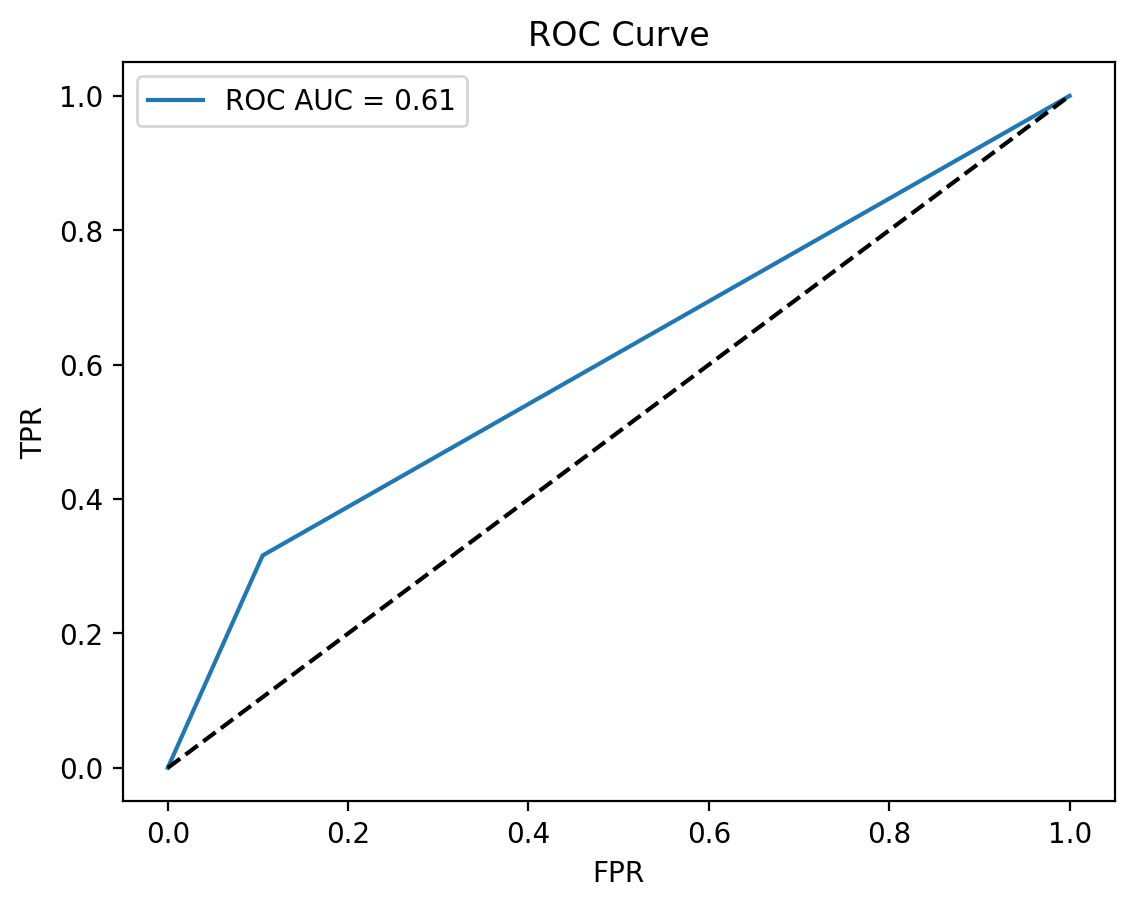

(<matplotlib.legend.Legend at 0x211f5407c40>, None)

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Compute ROC AUC
yprobs = dtc.predict_proba(Xtest)[:, 1]
auc_score = roc_auc_score(ytest, yprobs)

# Plot ROC Curve
fpr, tpr, _ = roc_curve(ytest, yprobs)
plt.plot(fpr, tpr, label=f'ROC AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR'), plt.ylabel('TPR'), plt.title('ROC Curve')
plt.legend(), plt.show()

In [ ]:
# Wrap classifier model within a class with threshold parameter
class ThresholdedClassifier:
    def __init__(self, model, threshold=0.5):
        self.model = model
        self.threshold = threshold

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return (self.model.predict_proba(X)[:, 1] >= self.threshold).astype(int)

    def predict_proba(self, X):
        return self.model.predict_proba(X)
    
# custom scoring with threshold
def threshold_scorer(ytrue, ypred_prob, threshold=0.5):
    ypred = (ypred_prob[:, 1] >= threshold).astype(int)
    return f1_score(ytrue, ypred)

In [15]:
param_grid = {
    'threshold': [0.1, 0.2, 0.3, 0.4]
}

# Perform grid search
grid_search = GridSearchCV(
    estimator=ThresholdedClassifier(DecisionTreeClassifier(random_state=42), threshold=0.5),
    scoring=make_scorer(threshold_scorer, greater_is_better=True),
    param_grid=param_grid, n_jobs=-1, cv=3
)

grid_search.fit(Xtrain, ytrain)

TypeError: Cannot clone object '<__main__.ThresholdedClassifier object at 0x000002005D6B42B0>' (type <class '__main__.ThresholdedClassifier'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

In [ ]:
# Try Gradient Boosting
gbc = GradientBoostingClassifier()
gbc.fit(Xtrain, ytrain)

# evaluate the best estimator on the test set
ypred = gbc.predict(Xtest)
yproba = gbc.predict_proba(Xtest)

gbc_score = precision_score(ytest, gbc.predict(Xtest))
print(f'default gbc precision: {gbc_score}')

prec = [round(scr, 4) for scr in precision_score(ytest, ypred, average=None)]
f1 = [round(scr, 3) for scr in f1_score(ytest, ypred, average=None)]
roc = round(roc_auc_score(ytest, ypred, multi_class='ovr'), 4)
interest_perf.loc[interest_perf.index.size] = ['gbc', prec, f1, roc]